<a href="https://colab.research.google.com/github/mma-fsa/urban_rural_heart_deaths/blob/main/2_geo_analysis_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Geographic Analysis & Clustering

Many determinents of health are correlated, as we'll see in this analysis.  For example:

* Diabetes and obesity are correlated with poverty.

* Lack of health insurance is correlated with poverty.  

* Smoking is more prevalent in rural areas.  

There are also geographic variations in the prevalence of the above variables, with some things (like obesity) being more prevalent in rural areas vs. urban.  

This analysis attempts to untangle geography and the correlated variables. If we are successful, the clusters will form geographically contiguous and meaningful regions, using only the non-geographic predictors.  If this occurs, we are effectively explaining the geographical correlations without actually drawing hard boundaries around particular regions.

In [1]:
# Install necessary libraries if not already installed
!pip install contextily
!wget https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/final_data.parquet

--2024-12-01 19:45:28--  https://github.com/mma-fsa/urban_rural_heart_deaths/raw/refs/heads/main/data/final_data.parquet
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/final_data.parquet [following]
--2024-12-01 19:45:29--  https://raw.githubusercontent.com/mma-fsa/urban_rural_heart_deaths/refs/heads/main/data/final_data.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827314 (808K) [application/octet-stream]
Saving to: ‘final_data.parquet’

final_data.parquet  100%[===================>] 807.92K  --.-KB/s    in 0.08s   

2024-12-01 19

## Load the pre-built data

The data in final_data.parquet is built in [1_create_data.ipynb](https://github.com/mma-fsa/urban_rural_heart_deaths/blob/main/1_create_data.ipynb), and sourced from the CDC, Census Bureau and USDA.

* We'll calculate the overall age-based mortality rate from

In [83]:
import pandas as pd
import geopandas as gpd
import numpy as np

df_cardiac_deaths = pd.read_parquet("final_data.parquet")

df_death_rate_by_age = df_cardiac_deaths.groupby(["AGE_GROUP"])\
  .agg({"DEATHS": "sum", "EXPOSURES": "sum"})

df_death_rate_by_age["RATE"] = df_death_rate_by_age["DEATHS"] / df_death_rate_by_age["EXPOSURES"]
df_death_rate_by_age = df_death_rate_by_age.drop(columns=["DEATHS", "EXPOSURES"])
df_cardiac_deaths = df_cardiac_deaths.merge(df_death_rate_by_age, on="AGE_GROUP")
df_cardiac_deaths["CRUDE_RISK_RATIO"] = (df_cardiac_deaths["DEATHS"] / df_cardiac_deaths["EXPOSURES"]) / (df_cardiac_deaths["RATE"])
df_cardiac_deaths["CRUDE_RISK_RATIO_CLIP"] = np.clip(df_cardiac_deaths["CRUDE_RISK_RATIO"], 0.5, 2)

df_cardiac_deaths

,COUNTY_DESC,FULL_FIPS,AGE_GROUP,AGE_GROUP_CODE,DEATHS,STATE_FIPS,COUNTY_FIPS,EXPOSURES,low_income,middle_income,...,SLEEP,MHLTH,KIDNEY,LPA,PHLTH,COREM,COREW,RATE,CRUDE_RISK_RATIO,CRUDE_RISK_RATIO_CLIP
0,"Autauga County, AL",01001,55-64 years,55-64,15.0,01,001,13922.0,0.050071,0.234661,...,37.5,16.2,2.8,26.4,10.7,44.0,41.3,0.001434,0.751423,0.751423
1,"Autauga County, AL",01001,65-74 years,65-74,39.0,01,001,9641.0,0.034489,0.367444,...,37.5,16.2,2.8,26.4,10.7,44.0,41.3,0.003143,1.287054,1.287054
2,"Baldwin County, AL",01003,45-54 years,45-54,25.0,01,003,56304.0,0.044385,0.279167,...,35.1,16.1,2.6,23.2,9.9,55.8,40.8,0.000568,0.781685,0.781685
3,"Baldwin County, AL",01003,55-64 years,55-64,73.0,01,003,63913.0,0.043258,0.247608,...,35.1,16.1,2.6,23.2,9.9,55.8,40.8,0.001434,0.796579,0.796579
4,"Baldwin County, AL",01003,65-74 years,65-74,127.0,01,003,57110.0,0.045232,0.324217,...,35.1,16.1,2.6,23.2,9.9,55.8,40.8,0.003143,0.707532,0.707532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5295,"Sheridan County, WY",56033,55-64 years,55-64,11.0,56,033,8612.0,0.021106,0.354669,...,31.9,13.3,2.4,20.4,8.4,50.0,32.3,0.001434,0.890807,0.890807
5296,"Sheridan County, WY",56033,65-74 years,65-74,21.0,56,033,8157.0,0.025691,0.320529,...,31.9,13.3,2.4,20.4,8.4,50.0,32.3,0.003143,0.819112,0.819112
5297,"Sweetwater County, WY",56037,55-64 years,55-64,10.0,56,037,10371.0,0.020099,0.229238,...,30.4,13.8,2.5,23.6,9.1,39.0,29.2,0.001434,0.672472,0.672472
5298,"Sweetwater County, WY",56037,65-74 years,65-74,21.0,56,037,7348.0,0.008840,0.251808,...,30.4,13.8,2.5,23.6,9.1,39.0,29.2,0.003143,0.909294,0.909294


In [84]:
# prompt: the column "Geolocation" contains a POINT string with latitude and longitude, convert it to a geopandas dataframe with

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Function to extract coordinates
def extract_coordinates(point_string):
    try:
        # Assuming format: POINT (longitude latitude)
        _, coordinates_str = point_string.split('(')
        coordinates_str = coordinates_str.strip(')')
        longitude, latitude = map(float, coordinates_str.split())
        return longitude, latitude
    except (ValueError, AttributeError):
        return None, None

# Apply the function and create new columns
df_cardiac_deaths[['Longitude', 'Latitude']] = df_cardiac_deaths['Geolocation'].apply(lambda x: pd.Series(extract_coordinates(x)))

# Create Point geometries
geometry = [Point(xy) for xy in zip(df_cardiac_deaths['Longitude'], df_cardiac_deaths['Latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_cardiac_deaths, geometry=geometry, crs="EPSG:4326")

# exclude hawaii and alaska
gdf = gdf[(gdf["STATE_FIPS"] != "02") & (gdf["STATE_FIPS"] != "15")].copy()

# Print some info or do further processing
print(gdf.head())

          COUNTY_DESC FULL_FIPS    AGE_GROUP AGE_GROUP_CODE  DEATHS  \
0  Autauga County, AL     01001  55-64 years          55-64    15.0   
1  Autauga County, AL     01001  65-74 years          65-74    39.0   
2  Baldwin County, AL     01003  45-54 years          45-54    25.0   
3  Baldwin County, AL     01003  55-64 years          55-64    73.0   
4  Baldwin County, AL     01003  65-74 years          65-74   127.0   

  STATE_FIPS COUNTY_FIPS  EXPOSURES  low_income  middle_income  ...   LPA  \
0         01         001    13922.0    0.050071       0.234661  ...  26.4   
1         01         001     9641.0    0.034489       0.367444  ...  26.4   
2         01         003    56304.0    0.044385       0.279167  ...  23.2   
3         01         003    63913.0    0.043258       0.247608  ...  23.2   
4         01         003    57110.0    0.045232       0.324217  ...  23.2   

   PHLTH  COREM  COREW      RATE  CRUDE_RISK_RATIO  CRUDE_RISK_RATIO_CLIP  \
0   10.7   44.0   41.3  0.001434 

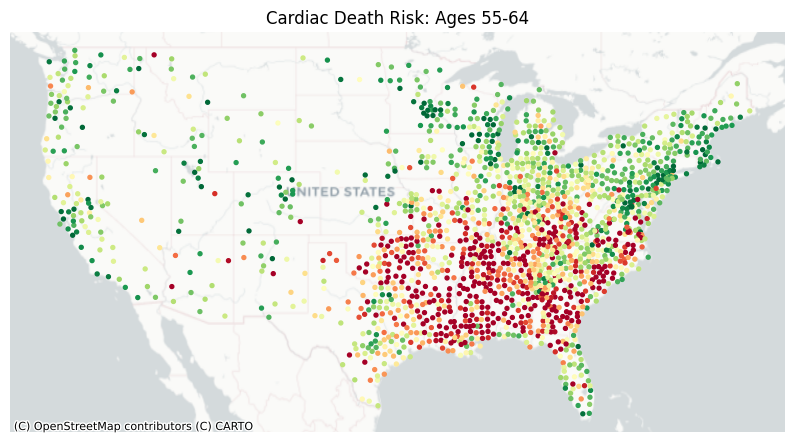

In [137]:
import matplotlib.pyplot as plt
import contextily as ctx

# Assuming 'gdf' and 'df_cardiac_deaths' are already defined from the previous code

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# set age groups
gdf_55_64 = gdf[(gdf["AGE_GROUP_CODE"] == "55-64")].copy()

# Plot the points, color based on CRUDE_RISK_RATIO
gdf_55_64.plot(column='CRUDE_RISK_RATIO_CLIP', ax=ax, cmap='RdYlGn_r', markersize=8)  # RdYlGn_r reverses the colormap

# Add a basemap
ctx.add_basemap(ax, crs=gdf_55_64.crs, source=ctx.providers.CartoDB.Positron) # or another basemap source

# Customize the plot (optional)
ax.set_title('Cardiac Death Risk: Ages 55-64')
ax.set_axis_off() # Turn off axis ticks and labels
plt.show()

In [103]:
df_cardiac_deaths.columns

Index(['COUNTY_DESC', 'FULL_FIPS', 'AGE_GROUP', 'AGE_GROUP_CODE', 'DEATHS',
       'STATE_FIPS', 'COUNTY_FIPS', 'EXPOSURES', 'low_income', 'middle_income',
       'poverty_income', 'upper_income', 'has_health_ins', 'no_health_ins',
       'has_pub_hi', 'no_pub_hi', 'pop_wt_ruca', 'PCT_MALE', 'Geolocation',
       'CHECKUP', 'STROKE', 'COPD', 'DENTAL', 'CASTHMA', 'CSMOKING',
       'COLON_SCREEN', 'CANCER', 'DIABETES', 'CERVICAL', 'DEPRESSION', 'CHD',
       'ARTHRITIS', 'BINGE', 'OBESITY', 'TEETHLOST', 'GHLTH', 'MAMMOUSE',
       'ACCESS2', 'SLEEP', 'MHLTH', 'KIDNEY', 'LPA', 'PHLTH', 'COREM', 'COREW',
       'RATE', 'CRUDE_RISK_RATIO', 'CRUDE_RISK_RATIO_CLIP', 'Longitude',
       'Latitude'],
      dtype='object')

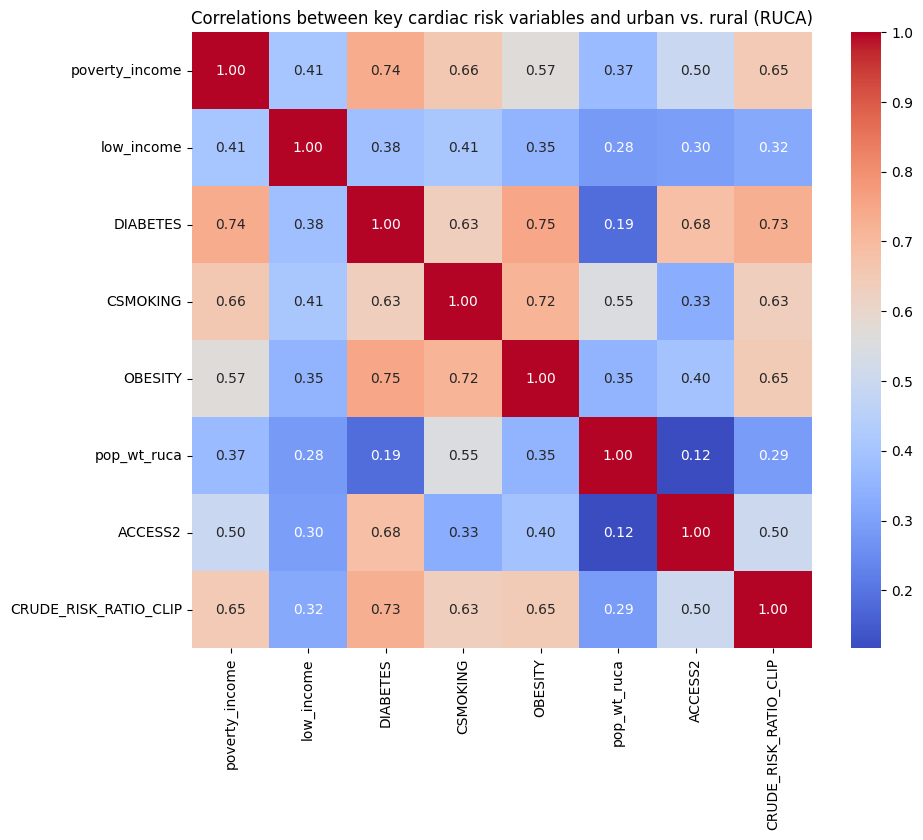

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_cardiac_deaths is already loaded and processed as in the previous code

# Select the columns for correlation
columns_for_correlation = ['poverty_income', 'low_income', 'DIABETES', 'CSMOKING', 'OBESITY', 'pop_wt_ruca', 'ACCESS2', 'CRUDE_RISK_RATIO_CLIP']

# Calculate Spearman correlations
correlation_matrix = df_cardiac_deaths[columns_for_correlation].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlations between key cardiac risk variables and urban vs. rural (RUCA)')
plt.show()

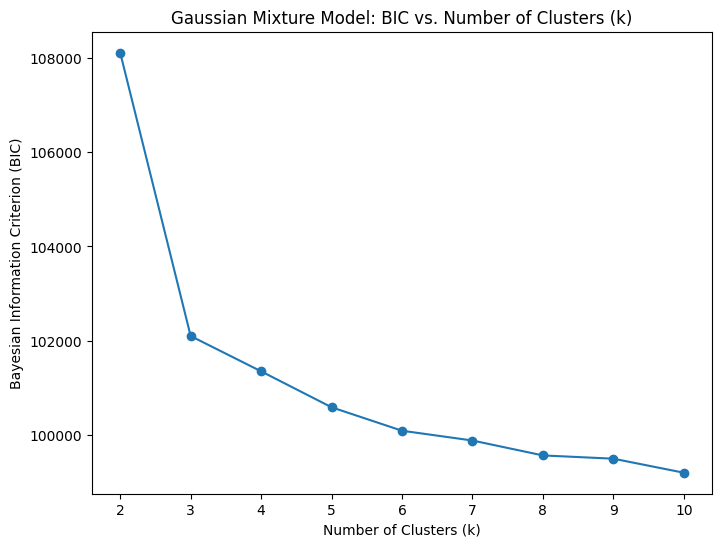

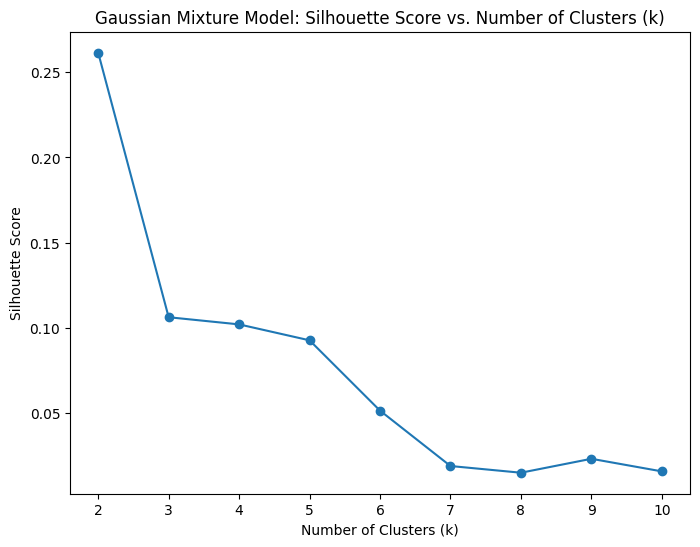

In [118]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select the features for clustering
features = ['poverty_income', 'DIABETES', 'CSMOKING', 'OBESITY', 'pop_wt_ruca', 'ACCESS2']
X = gdf[features]

# Find optimal number of clusters using within-cluster SSE
sse = []
silhouette = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)  # Set random_state for reproducibility
    gmm.fit(X)
    labels = gmm.predict(X)
    sse.append(gmm.bic(X))
    silhouette.append(silhouette_score(X, labels))

# Plot within-cluster SSE
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Gaussian Mixture Model: BIC vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette, marker='o')
plt.title('Gaussian Mixture Model: Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [174]:
# Assuming optimal number of clusters (k) has been determined (e.g., k=3 based on the plots)
optimal_k = 7  # Replace with your optimal k value

# Fit the Gaussian Mixture Model with the optimal k
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(X)

# Predict cluster assignments for each row
gdf['cluster'] = gmm.predict(X)

# Get the centroids for each cluster
centroids = pd.DataFrame(gmm.means_, columns=features)
print("Centroids of each cluster:")
centroids

Centroids of each cluster:


,poverty_income,DIABETES,CSMOKING,OBESITY,pop_wt_ruca,ACCESS2
0,0.150144,9.886046,16.542088,33.077288,1.127495,14.912222
1,0.213042,11.113644,22.690718,38.717096,4.587878,17.494282
2,0.256866,12.596415,21.881760,39.221065,5.584807,20.599262
3,0.212789,10.761581,23.901464,38.529068,5.165260,11.895194
4,0.199827,12.399228,18.963007,37.992149,3.550724,31.726624
5,0.188599,10.312005,17.982912,33.660321,2.801238,18.575442
6,0.151139,8.938848,19.120691,34.711540,4.604257,12.094101


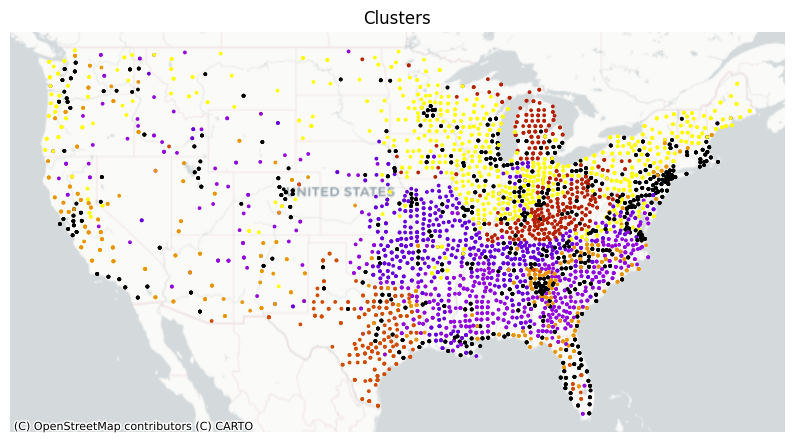

In [175]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(column='cluster', ax=ax, cmap='gnuplot', markersize=3)  # RdYlGn_r reverses the colormap

# Add a basemap
ctx.add_basemap(ax, crs=gdf_55_64.crs, source=ctx.providers.CartoDB.Positron) # or another basemap source

# Customize the plot (optional)
ax.set_title('Clusters')
ax.set_axis_off() # Turn off axis ticks and labels
plt.show()

In [176]:
df_cluster_death_rates = gdf.groupby(["AGE_GROUP_CODE", "cluster"]).agg({"EXPOSURES": "sum", "DEATHS": "sum"})
df_cluster_death_rates["RATE"] = df_cluster_death_rates["DEATHS"] / df_cluster_death_rates["EXPOSURES"]
df_cluster_death_rates

EXPOSURES    DEATHS      RATE
AGE_GROUP_CODE cluster                                
35-44          0        42921372.0    8554.0  0.000199
               1          418765.0     196.0  0.000468
               2          147285.0     101.0  0.000686
               3          269284.0     103.0  0.000382
               4         3245595.0     751.0  0.000231
               5         2236107.0     519.0  0.000232
               6          654284.0     130.0  0.000199
45-54          0        46631125.0   24531.0  0.000526
               1         1618611.0    1668.0  0.001031
               2          845670.0    1203.0  0.001423
               3          879473.0     707.0  0.000804
               4         3534811.0    2208.0  0.000625
               5         4035403.0    2342.0  0.000580
               6         2901994.0    1628.0  0.000561
55-64          0        48664170.0   64511.0  0.001326
               1         2982585.0    6656.0  0.002232
               2         2220013.0    5659.0  0.002549
               3         2062723.0    3651.0  0.001770
               4         3562791.0    5650.0  0.001586
               5         5115536.0    7589.0  0.001484
               6         6617956.0    8305.0  0.001255
65-74          0        36475340.0  107837.0  0.002956
               1         2627312.0   11416.0  0.004345
               2         2058848.0    9923.0  0.004820
               3         1917581.0    6966.0  0.003633
               4         2707270.0    9573.0  0.003536
               5         4427354.0   13903.0  0.003140
               6         6271563.0   17856.0  0.002847

In [160]:
df_cluster_death_rates.to_json("cluster_death_rates.json")

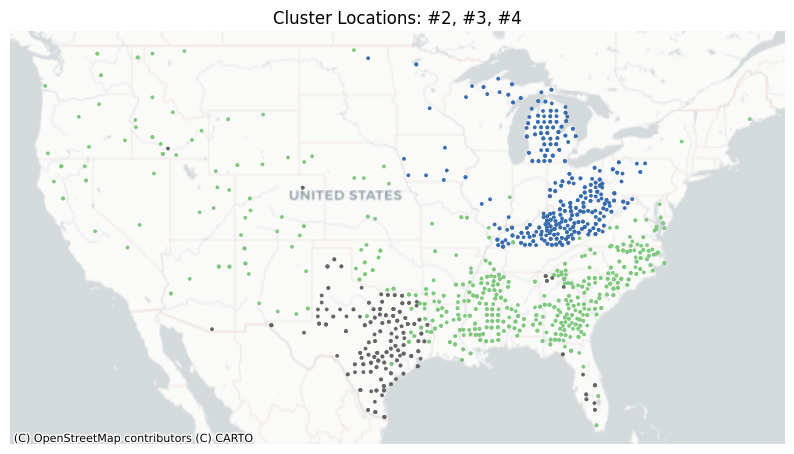

In [169]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# set age groups
gdf_clusters = gdf[(gdf["cluster"].isin([2, 3, 4]))].copy()

# Plot the points, color based on CRUDE_RISK_RATIO
gdf_clusters.plot(column='cluster', ax=ax, cmap='Accent', markersize=3)  # RdYlGn_r reverses the colormap

# Add a basemap
ctx.add_basemap(ax, crs=gdf_clusters.crs, source=ctx.providers.CartoDB.Positron) # or another basemap source

# Customize the plot (optional)
ax.set_title('Cluster Locations: #2, #3, #4')
ax.set_axis_off() # Turn off axis ticks and labels
plt.show()

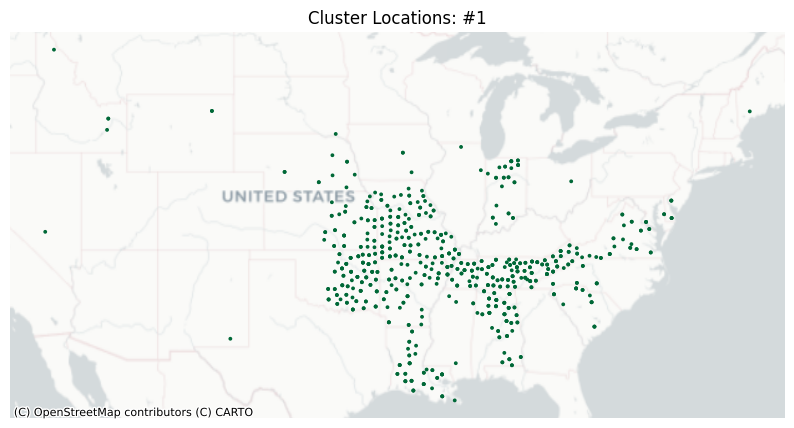

In [162]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# set age groups
gdf_clusters = gdf[(gdf["cluster"].isin([1]))].copy()

# Plot the points, color based on CRUDE_RISK_RATIO
gdf_clusters.plot(column='cluster', ax=ax, cmap='RdYlGn_r', markersize=3)  # RdYlGn_r reverses the colormap

# Add a basemap
ctx.add_basemap(ax, crs=gdf_clusters.crs, source=ctx.providers.CartoDB.Positron) # or another basemap source

# Customize the plot (optional)
ax.set_title('Cluster Locations: #1')
ax.set_axis_off() # Turn off axis ticks and labels
plt.show()

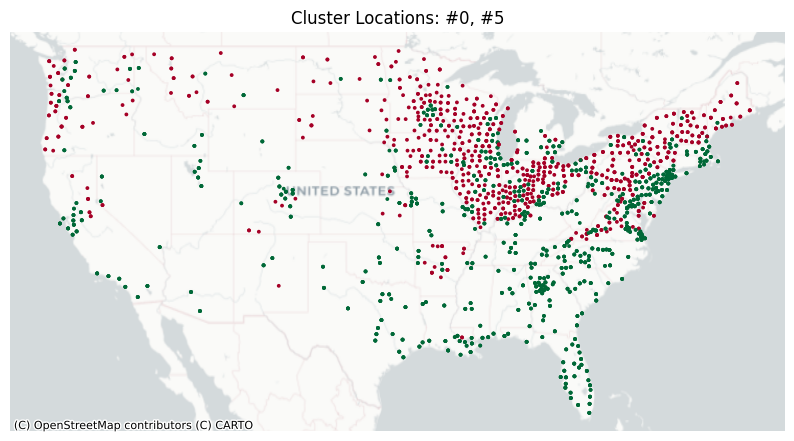

In [177]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# set age groups
gdf_clusters = gdf[(gdf["cluster"].isin([0, 6]))].copy()

# Plot the points, color based on CRUDE_RISK_RATIO
gdf_clusters.plot(column='cluster', ax=ax, cmap='RdYlGn_r', markersize=3)  # RdYlGn_r reverses the colormap

# Add a basemap
ctx.add_basemap(ax, crs=gdf_clusters.crs, source=ctx.providers.CartoDB.Positron) # or another basemap source

# Customize the plot (optional)
ax.set_title('Cluster Locations: #0, #5')
ax.set_axis_off() # Turn off axis ticks and labels
plt.show()

In [155]:
gdf.to_parquet("final_data_with_clusters.parquet")

In [159]:
with open('final_data_with_clusters.geojson', 'w') as f:
    f.write(gdf.to_json())
